<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Model-agnostic Explanations**


Estimated time needed: **45** minutes


In this lab, we will first train a random forest model to predict if employees are looking for a job change, then we want to interpret the trained model in order to understand how exactly it makes predictions. Since random forest model is normally very complex to understand, we will just treat it as a black-box model first. Then, you will have the practice opportunities to apply various model-agnostic explanation methods to explain the black-box model.


## Objectives


After completing this lab you will be able to:


* Calculate Permutation Feature Importance
* Use Partial Dependency Plot to illustrate relationships between feature and outcomes
* Build Global Surrogate Models
* Build Local Surrogate Models using `LIME`


----


## Setup


Let's first import required Python packages for this lab:


And then import the required Python packages.


In [4]:
## Import packages here
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import lime.lime_tabular

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from sklearn.inspection import permutation_importance, PartialDependenceDisplay


Then, let's load the dataset to be used in this lab.


In [2]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/hr_new_job_processed.csv"
job_df=pd.read_csv(url)

In [3]:
job_df.describe()

,city_development_index,training_hours,company_size,experience,education_level,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,target
count,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000
mean,0.806056,64.380421,2.748997,9.530985,2.131568,0.029180,0.042537,0.023619,0.005557,0.045442,0.853665,0.500000
std,0.128302,59.048600,1.783676,6.733267,0.627610,0.161802,0.197495,0.147348,0.070875,0.200717,0.342167,0.500022
min,0.448000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.682000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.878000,46.000000,2.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000
75%,0.920000,88.000000,3.000000,15.000000,2.247823,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,0.949000,336.000000,7.000000,21.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The dataset contains the following features (predictors):

- `city_ development index` : Developement index of the city, ranged from 0 to 1
- `training_hours`: Training hours completed, ranged from 0 to 336
- `company_size`: Size of the current company, ranged from 0 to 7 where 0 means less than 10 employees and 7 means more than 10,000 employees
- `education_level`: Education level of the candidate, ranged from 0 to 4 where 0 means Primary School and 4 means Phd
- `experience`: Total experience in years, ranged from 0 to 21
- `company_type` : _Categorical column_ with one-hot encodings. Type of current company:  'Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other', 'Public Sector', 'NGO'

and the prediction outcome is:
- `target`: `0` – Not looking for a job change, `1` – Looking for a job change


The predictive task is a straightforward binary classification task, more specifically, we want to use an employee's profile features to predict if he/she is looking for a job change or not.


## Build a Random Forest classifier as the Black-box model


### Split the training and testing datasets


In [5]:
X = job_df.loc[:, job_df.columns != 'target']
y = job_df[['target']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 12)

Now let's train a `Random Forest` model with the following preset arguments. If you like, you may also use hyperparameter tuning methods to tune these parameters yourself.
- `random_state = 0` as a random seed to reproduce the result
- `max_depth = 25` means the max depth of a tree should be less than 25
- `max_features = 10` means the random forest includes max 10 features
- `n_estimators = 100` means total 100 trees will be built
- `bootstrap = True` means bootstrap samples will be used to build trees


In [7]:
# Define a black-box random forest model
black_box_model = RandomForestClassifier(random_state = 123, max_depth=25, 
                             max_features=10, n_estimators=100, 
                             bootstrap=True)
# Train the model
black_box_model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=25, max_features=10, random_state=123)

Next, let's make some predictions and evalute the model using `AUC` score:


In [8]:
#predicting test set
y_blackbox = black_box_model.predict(X_test)

In [9]:
metrics.roc_auc_score(y_test, y_blackbox)

0.8131250708268802

Your AUC score should be around `0.81`, which indicates the model is doing a very good job in the test dataset.


Now we have a black-box random forest model trained, we want to use various model-agnostic methods to explain it. 


Note that if you prefer other binary classification models such as XGBoosting, you could train one here by yourself as well, and it won't affect
the subsequent steps since our explanations are all model-agnostic.


## Permutation Feature Importance


One common way to explain a machine learning model is via finding its important features and **permutation feature importance** is a popular method to calculate feature importance.


The basic idea of permutation feature importance is we shuffle interested feature values and make predictions using the shuffled values. 
The feature importance will be measured by calculating the difference between the prediction errors before and after permutation.


In this lab, we will use `permutation_importance` function provided by `sklearn` to easily calculate importance for all features.


You can call `permutation_importance` with the following key arguments:
- `estimator` the model to be estimated
- `X` training data X
- `y` target labels y
- `n_repeats`, Number of times to permute a feature, each permutation generates an importance value


In [10]:
# Use permutation_importance to calculate permutation feature importances
feature_importances = permutation_importance(estimator=black_box_model, X = X_train, y = y_train, n_repeats=5,
                                random_state=123, n_jobs=2)

Let's take a look at the generated importance results:


In [11]:
feature_importances.importances.shape

(11, 5)

In [12]:
feature_importances.importances

array([[0.30468326, 0.30109747, 0.30392263, 0.30174943, 0.30479192],
       [0.15527545, 0.15103771, 0.15092904, 0.15190699, 0.15603608],
       [0.18200587, 0.18309247, 0.18537433, 0.18254917, 0.18993806],
       [0.15353689, 0.15114637, 0.15168967, 0.1472346 , 0.1562534 ],
       [0.1201782 , 0.11789634, 0.11561447, 0.11659242, 0.11517983],
       [0.00076062, 0.00065196, 0.00097794, 0.0005433 , 0.0005433 ],
       [0.00206454, 0.00206454, 0.0021732 , 0.00206454, 0.0016299 ],
       [0.00130392, 0.00141258, 0.00141258, 0.00152124, 0.00119526],
       [0.00076062, 0.0005433 , 0.00065196, 0.0005433 , 0.0005433 ],
       [0.00988808, 0.01043138, 0.00988808, 0.01097468, 0.01097468],
       [0.04813648, 0.04857112, 0.04563729, 0.04704988, 0.04900576]])

It is a `11 x 5` numpy array, 11 means we have 11 features, and 5 represents the total number of permutation times. 

For each permutation, we will have a list of importance score calculated for each feature. The value represents the portion of increased prediction errors, important features will have larger values.


However, the feature importance array above is very difficult to comprehend, let's sort and visualize it:


In [13]:
def visualize_feature_importance(importance_array):
    # Sort the array based on mean value
    sorted_idx = importance_array.importances_mean.argsort()
    # Visualize the feature importances using boxplot
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(10)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])
    ax.set_title("Permutation Importances (train set)")
    plt.show()

C:\Users\sam\AppData\Local\Temp\ipykernel_21708\1395202523.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(importance_array.importances[sorted_idx].T,


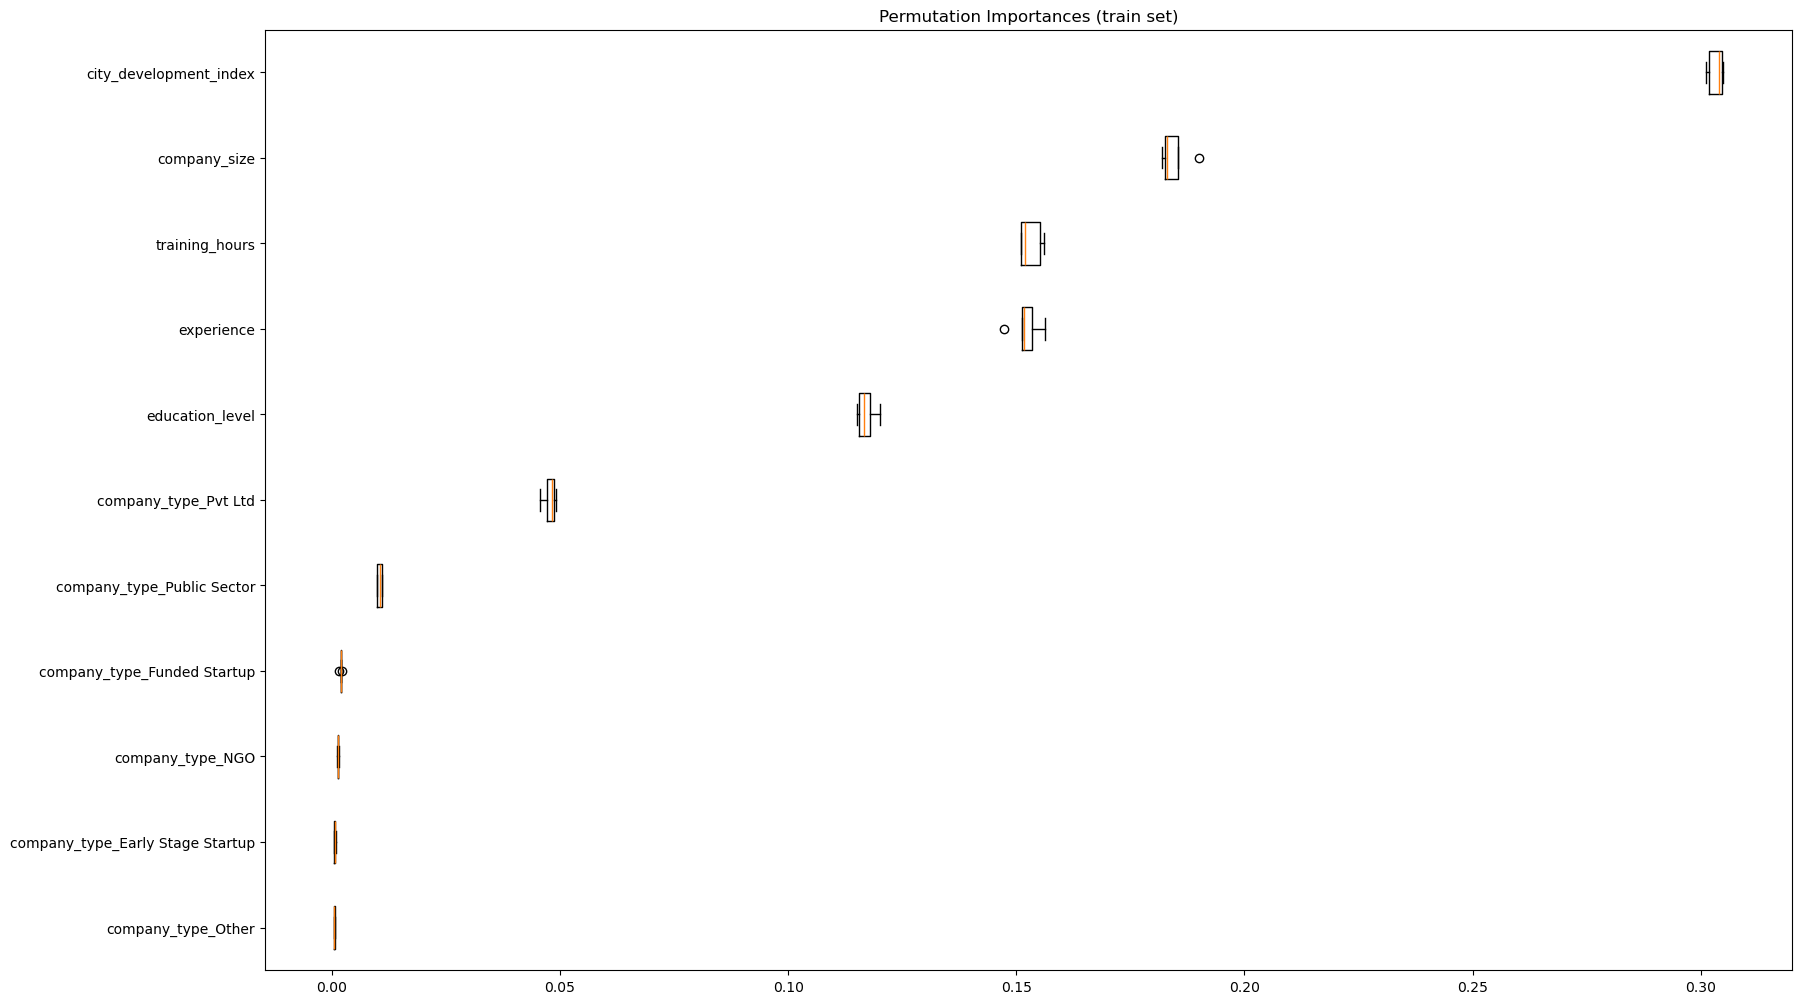

In [14]:
visualize_feature_importance(feature_importances)

Now you should see a box plot show ranked feature importances, and we can see the most important features are `city_development_index`, `company_size`, `training_hours`, `experiences`, `education_level`, and so on, and you should have a general understanding of how the black-box model determines if an employee is looking for a new job or not.


### Exercise: Use a different `n_repeats=10` to calculate and visualize feature importance values  


C:\Users\sam\AppData\Local\Temp\ipykernel_21708\1395202523.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(importance_array.importances[sorted_idx].T,


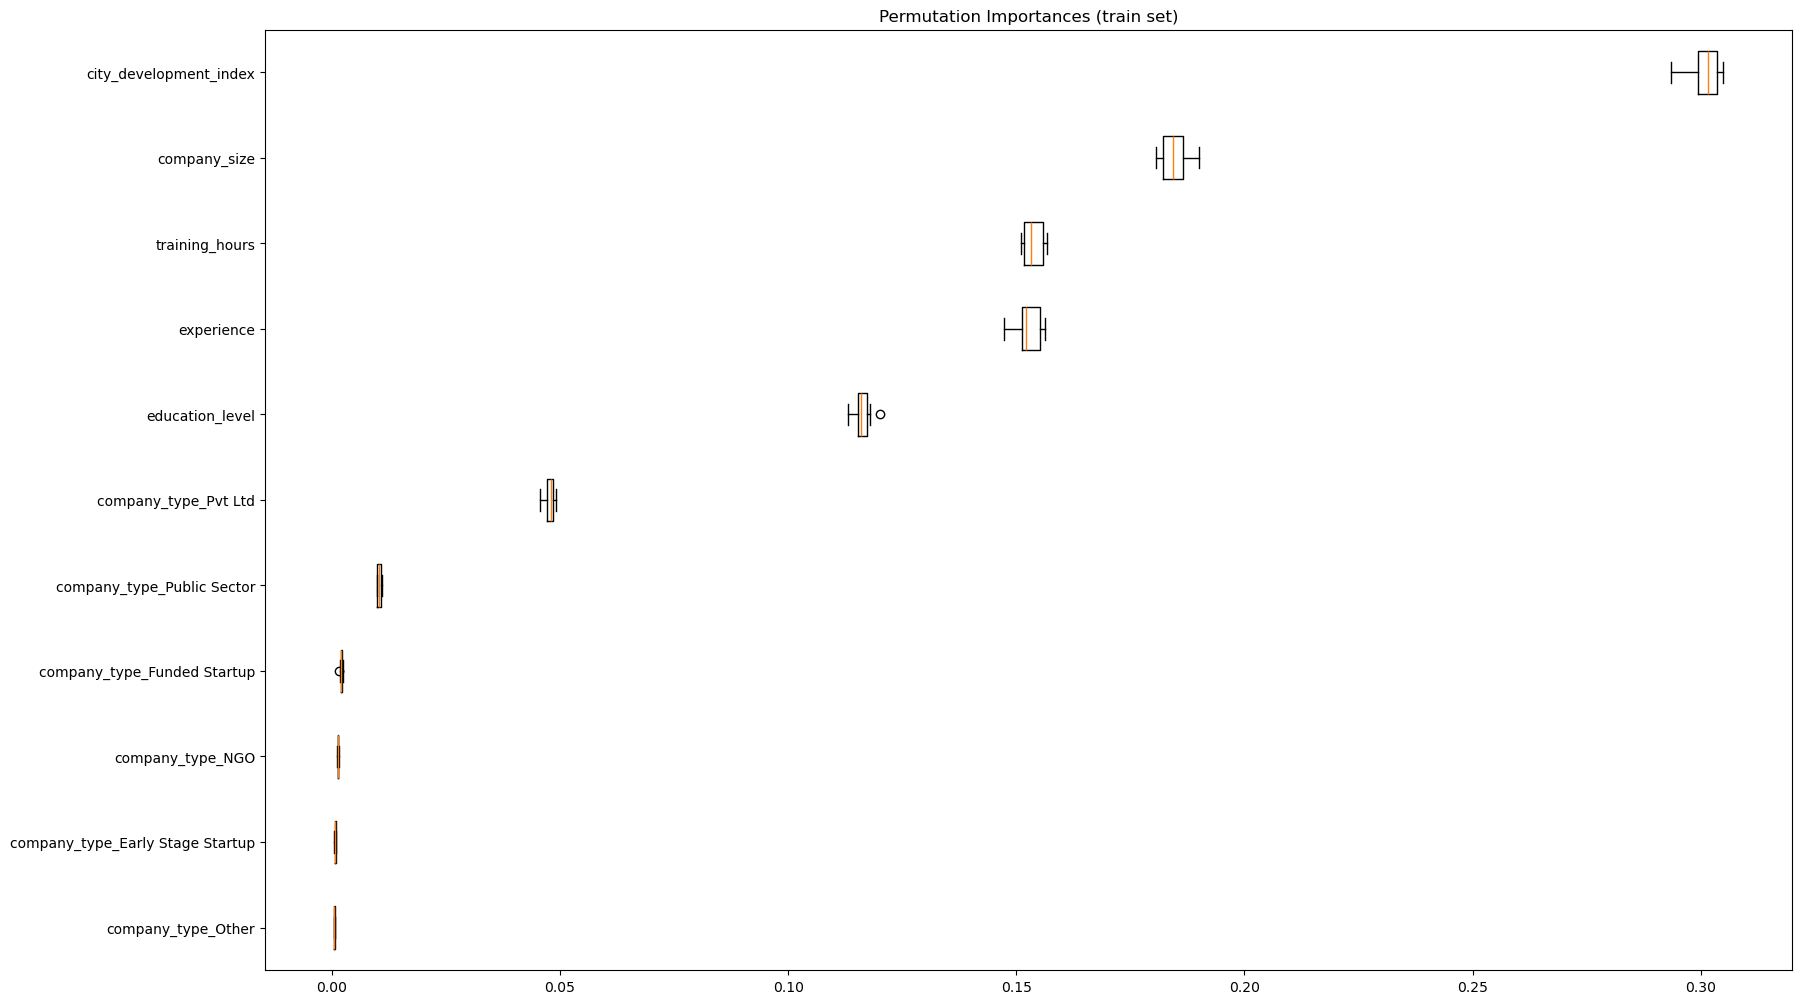

In [15]:
# Type your answer here
# Update n_repeats=10 and recalculate and visualize feature importance
feature_importances = permutation_importance(estimator=black_box_model, X = X_train, y = y_train, n_repeats=10,
                                random_state=123, n_jobs=2)

visualize_feature_importance(feature_importances)

<details><summary>Click here for a sample solution</summary>

```python
feature_importances = permutation_importance(estimator=black_box_model, X = X_train, y = y_train, n_repeats=10,
                                random_state=123, n_jobs=2)

visualize_feature_importance(feature_importances)

```

</details>


## Partial Dependency Plot (PDP)


Partial Dependency Plot (PDP) is an effective way to illustrate the relationship between an interested feature and the model outcome. It essentially visualizes the marginal effects of a feature, that is, shows how the model outcome changes when a specific feature changes in its distribution.


Since a machine learning model may include many features, and it is not feasible to create PDP for every single feature. Thus, we normally first find the most important features via ranking their feature importances. Then, we can only focus PDP on those important features.


From the previous step, we know some important features are `city_development_index`, `company_size`, `experience`, `education_level`, and we can easily create PDP for those features using `PartialDependenceDisplay` in `sklearn` package.


Let's first try to create PDP for features `city_development_index`, `experience`:


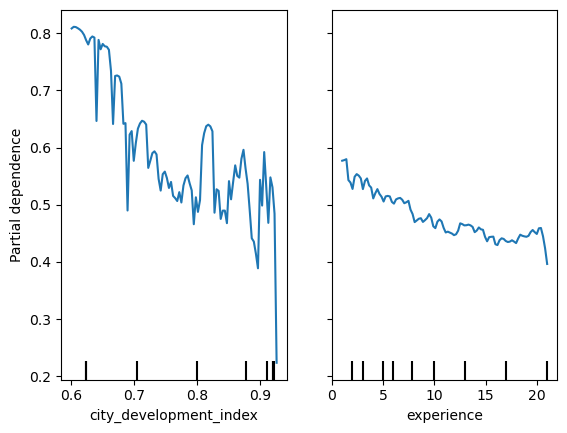

In [16]:
# Define important features
important_features = ['city_development_index', 'experience']

# Use PartialDependenceDisplay to plot the partial dependence
PartialDependenceDisplay.from_estimator(estimator=black_box_model, 
                                        X=X_train, 
                                        features=important_features, 
                                        random_state=123)
plt.show()

Then you should see two PDPs are plotted for `city_development_index` and `experience`. They all have roughly negative linear relationship betweens the outcome, for example, if an employee is in a well-developed city and has a lot of experiences, then he/she is unlikely to change the current job.


### Exercise: Create PDPs for other important features such as `company_size`, `education_level`, `training_hours`, and others


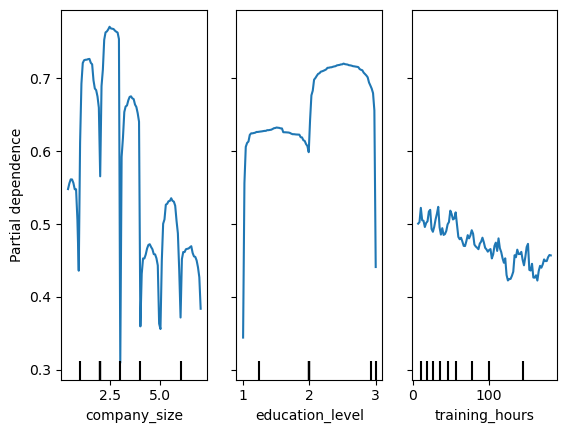

In [17]:
# Type your solution here
# Create PDPs for other important features
important_features = ['company_size', 'education_level', 'training_hours']
    
PartialDependenceDisplay.from_estimator(estimator=black_box_model, 
                        X=X_train, 
                        features=important_features,
                        random_state=123)

<details><summary>Click here for a sample solution</summary>

```python
important_features = ['company_size', 'education_level', 'training_hours']
    
PartialDependenceDisplay.from_estimator(estimator=black_box_model, 
                        X=X_train, 
                        features=important_features,
                        random_state=123)
```

</details>


## Global Surrogate Model


Now you have explored how to explain the black-box model via analyzing its features. Next, we will learn how to explain it via approximate of their inputs and outputs with a global surrogate model.


We will be training two self-interpretable models: 1) a logistic regression model and 2) a decision tree models using the inputs and outputs from the black-box model


You can follow these general steps to build a global surrogate model:

- First, we select a dataset `X_test` as input

- Then, we use the black-box model to make predictions `y_blackbox` using the `X_test`

- With both training data and labels ready, we can use them to train a simple logistic regression model and a decision tree model

- The surrogate model outputs its own predictions `y_surrogate`

- Lastly, we can measure the difference between `y_surrogate` and `y_blackbox` using an accuracy score to determine how well the surrogate model approximating the black-box model


### Logistic regression surrogate model


In order to compare the coefficients of the logistic regression model directly, we want to normalize the input X first.


In [18]:
# normalize X_test
min_max_scaler = StandardScaler()
X_test_minmax = min_max_scaler.fit_transform(X_test)

Then, we can train a logistic regression model with an `L1` regularizer to simplify the model and increase interpretability. Note that `y_blackbox` is coming from the predictions of black-box model.


In [19]:
lm_surrogate = LogisticRegression(max_iter=1000, 
                                  random_state=123, penalty='l1', solver='liblinear')
lm_surrogate.fit(X_test_minmax, y_blackbox)

LogisticRegression(max_iter=1000, penalty='l1', random_state=123,
                   solver='liblinear')

With the surrogate model trained, we can generate predictions using `X_test`, 


In [20]:
y_surrogate = lm_surrogate.predict(X_test_minmax)

and calculate how accurate the surrogate model approximates the black-box model.


In [21]:
metrics.accuracy_score(y_blackbox, y_surrogate)

0.7431551499348109

The score is around 0.75 which means the logistic regression surrogate model was able to reproduce about 75% of the original black-box model correctly.


Next, we can start interpreting the much simpler logistic regression model `lm_surrogate` via analyzing its feature coefficients. We defined a function called `get_feature_coeffs` to extract and sort feature coefficients from `lm_surrogate` model:


In [22]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model):
    coef_dict = {}
    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X_test.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

In [23]:
coef_dict = get_feature_coefs(lm_surrogate)
coef_dict

{'city_development_index': -1.1037003758316433,
 'experience': -0.31534600537812607,
 'company_size': -0.3102667491190301,
 'company_type_Funded Startup': -0.20164083670299643,
 'training_hours': -0.1590867045051154,
 'company_type_Early Stage Startup': -0.13134779175452335,
 'company_type_NGO': -0.052803892359036986,
 'company_type_Other': 0.07697385537422011,
 'education_level': 0.1526050373206213,
 'company_type_Pvt Ltd': 0.4424638344649262}

We can get a coefficient dict object whose keys are features and values are coefficients, but such dict object is not easy to understand so let's just visualize it using a bar chart:


In [24]:
# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()
    

Let's call `visualize_coefs` function to visualize the coefficients dict:


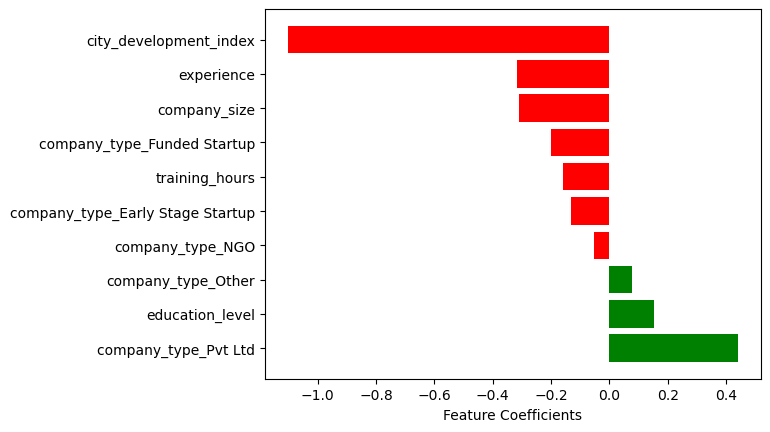

In [25]:
visualize_coefs(coef_dict)

From the bar chart above, you can immediately find those important features with negative effects such as `city_development_index` and `experience`, and those have positive effects such as education_level or if the company is a `Pvt Ltd`.


### Exercise: Build a global surrogate model using decision tree


In [26]:
# Type your answer here
# Define a decision tree model
tree_surrogate = DecisionTreeClassifier(random_state=123, 
                                         max_depth=5, 
                                         max_features=10)

<details><summary>Click here for a sample solution</summary>

```python
tree_surrogate = DecisionTreeClassifier(random_state=123, 
                                         max_depth=5, 
                                         max_features=10)
```

</details>


In [27]:
# Type your answer here
# Train the decision tree model with X_test and y_blackbox, and make predictions on X_test
tree_surrogate.fit(X_test, y_blackbox)
y_surrogate = tree_surrogate.predict(X_test)

<details><summary>Click here for a sample solution</summary>

```python
tree_surrogate.fit(X_test, y_blackbox)
y_surrogate = tree_surrogate.predict(X_test)
```

</details>


In [28]:
# Type your answer here
# Measure the difference between
metrics.accuracy_score(y_blackbox, y_surrogate)

0.8213820078226858

<details><summary>Click here for a sample solution</summary>

```python
metrics.accuracy_score(y_blackbox, y_surrogate)
```

</details>


Now, you have trained the tree surrogate model, you could interprete it by export and print the tree:


In [29]:
tree_exp = export_text(tree_surrogate, feature_names=list(X_train.columns))

In [30]:
print(tree_exp)

|--- city_development_index <= 0.70
|   |--- experience <= 20.92
|   |   |--- training_hours <= 304.03
|   |   |   |--- company_type_Funded Startup <= 0.99
|   |   |   |   |--- city_development_index <= 0.69
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- city_development_index >  0.69
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- company_type_Funded Startup >  0.99
|   |   |   |   |--- education_level <= 2.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- education_level >  2.50
|   |   |   |   |   |--- class: 0.0
|   |   |--- training_hours >  304.03
|   |   |   |--- class: 0.0
|   |--- experience >  20.92
|   |   |--- city_development_index <= 0.67
|   |   |   |--- education_level <= 2.07
|   |   |   |   |--- training_hours <= 44.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- training_hours >  44.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- education_level >  2.07
|   |   |   |   |--- company_size <= 6.50
|   |   |   |   |   |--- cla

## Local interpretable model-agnostic explanations (LIME)


Global surrogate models may have large prediction inconsistency between the complex black-box model and the simple surrogate models or there are many instance groups or clusters in the dataset which make the surrogate model more generalized to those different patterns and lose the interpretability on a specific data group. 

On the other hand, we are also interested in how black-box models make predictions on some representative instances. By understanding these very typical examples, we can sometimes obtain valuable insights without understanding the model’s behaviors on the entire dataset.


Next, you will be building a local surrogate model using LIME method whose general steps are shown in the following flowchart:


![Local interpretable model-agnostic method](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/module6_model_interpretability/images/lime.png)


We can use a open source [lime](https://github.com/marcotcr/lime) package to easily build a LIME explainer the our black-box model, let's get started.


First, we need to define a `LimeTabularExplainer` to explain those predictive models built on structured/tabular datasets, like the job-changing prediction dataset we are using.


Note although LIME algorithm is a local surrogate model, it still also requires a training dataset containing your interested data instances. So that it can perform uniform sampling (feature permutations) around the interested data instances to generate the artificial dataset for the actual surrogate model training process.


In [31]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    # Set the training dataset to be X_test.values (2-D Numpy array)
    training_data=X_test.values,
    # Set the mode to be classification
    mode='classification',
    # Set class names to be `Not Changing` and `Changing`
    class_names = ['Not Changing', 'Changing'],
    # Set feature names
    feature_names=list(X_train.columns),
    random_state=123,
    verbose=True)

Now, let's try to select an interested employee from `X_test`, and we want to understand its prediction using the `LimeTabularExplainer`.


In [32]:
instance_index = 19
selected_instance = X_test.iloc[[instance_index]]
lime_test_instance = selected_instance.values.reshape(-1)
selected_instance

,city_development_index,training_hours,company_size,experience,education_level,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
8659,0.924,74.0,7.0,16.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0


Let's make a quick summary about this employee:
- His/her city is well-developed with a city development index > 0.9
- His/her training hour is 74 hours
- His/her company is a very big company, 7 means more than 10,000 employees
- His/her experience is more than 16 years
- His/her company is a Pvt Ltd (Private) company
- His/her has Master's degree(s)

and our black-box model predicts its probability of changing a job is `0.03`, that is, very unlikely to leave his or her current job.


Then, let's use `LimeTabularExplainer` to explain why the black-box model thinks this employee won't leave his/her current job.


c:\Users\sam\anaconda3\envs\API\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Intercept 0.9292244657555584
Prediction_local [0.48730243]
Right: 0.030869565217391304


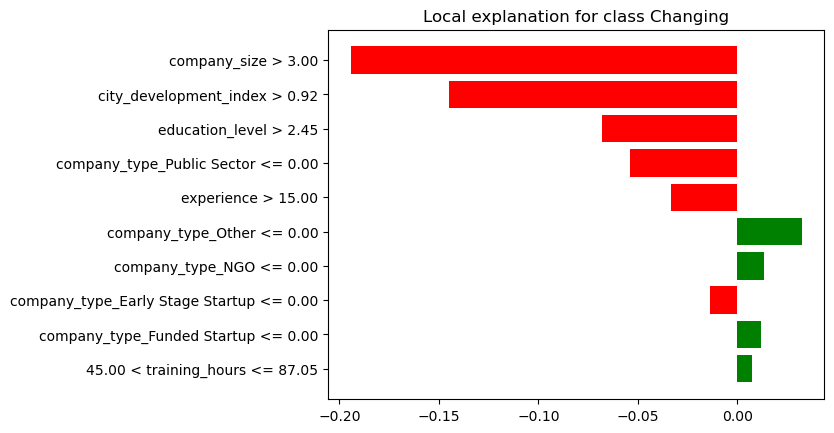

In [33]:
exp = explainer.explain_instance(
                                 # Instance to explain
                                 lime_test_instance, 
                                 # The prediction from black-box model
                                 black_box_model.predict_proba,
                                 # Use max 10 features
                                 num_features=10)
exp.as_pyplot_figure();

`LimeTabularExplainer` outputs a bar chart similar to the coefficient or feature importance chart we plotted before. 
From its output, we can easily interpret why the black-box thinks this employe won't change job, based on the following main factors:
- His/her company is a very big company
- His/her city is well-developed with city development
- His/her highest degree is Master or above
- His/her experience is more than 15 years
- His/her company is not NGO or Startup

This interpretation is also aligned with our common sense, that is, if a well-educated employee has been working in a very big/good private company, located in a big city, for more than 15 years, then he/she is probably very satisfied with current job and does not want to change it.


## Next Steps


By now you have learned and applied various model-agnostic explanation algorithms such as Permutation Feature Importance, PDP, Global Surrogate Model, LIME, and others in this lab. There are many other such methods such as Feature Interactions, Individual Conditional Expectation, SHAP values, and so on, and we do not have enough time to explain them all in this course. 

We list the references to other popular model explanation methods which you may be interested:
- [Predictive learning via rule ensembles](https://arxiv.org/abs/0811.1679)
- [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874)
- [Peeking Inside the Black Box: Visualizing Statistical Learning with Plots of Individual Conditional Expectation](https://arxiv.org/abs/1309.6392)


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)


### Other Contributors


<!--## Change Log
--!>


<!--|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2021-8-23|1.0|Yan|Created the initial version||2022-2-8|1.1|Steve Hord|QA pass|--!>


Copyright © 2021 IBM Corporation. All rights reserved.
